In [4]:
!pip install scipy
import torch, numpy as np
from utils import unpack_sym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ms_file = 'data/feature_engineering_data.h5'


  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/fc/da/452e1119e6f720df3feb588cce3c42c5e3d628d4bfd4aec097bd30b7de0c/scipy-1.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 18.3 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import sys
sys.path.append('./feature_engineering/')
import feature_extraction as extract
from utils import MicrostructureImageDataset

MS_train = MicrostructureImageDataset(file_path=ms_file, group_name= 'train_set', dset_name='image_data')
MS_bench = MicrostructureImageDataset(file_path=ms_file, group_name= 'benchmark_set', dset_name='image_data')

image_index = 17875
image = MS_train[image_index]

kappa0 = 2.97654        # isotropric thermal heat conductivity of the matrix material
kappa1 = 98.03453       # isotropic thermal heat conductivity of the inclusion material
R = kappa0/kappa1       # Phase contrast ratio

image = np.expand_dims(image.cpu().numpy(), axis=0)
print(image.shape, image.dtype)
print(image)
train_feature = extract.full_computation(image) 
train_feature = torch.tensor(np.append(train_feature, [[1/R, R]], axis=1), device=device, dtype=torch.float32)

(1, 400, 400) float32
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
Initializing timer for this tag: rb loading and processing
rb loading and processing -> elapsed time: 0.0761
Initializing timer for this tag: full feature computation of 1 samples
fft -> elapsed time: 0.0028
xi computation -> elapsed time: 0.0088
band features -> elapsed time: 0.0224
projected edges -> elapsed time: 0.0002
local volume -> elapsed time: 0.0017
edge distributions -> elapsed time: 0.0143
full feature computation of 1 samples -> elapsed time: 0.0506
length of each feature type: [(1, 1), (1, 13), (1, 16), (1, 2), (1, 7), (1, 12)]


tensor([[ 4.0952e-01, -5.6918e+01, -3.4999e+01, -2.2401e+00,  9.7522e+00,
          1.9465e+01,  2.1559e-01,  5.3100e-01,  8.2142e-01,  4.1233e-01,
          1.4600e-02,  5.1082e-01,  1.2343e+00, -6.7536e-01,  5.7300e-01,
          7.3112e-01,  8.1311e-01,  1.0000e+00,  7.8444e-01,  1.0000e+00,
          8.2005e-01,  1.0000e+00,  6.3607e-01,  1.0000e+00,  7.4061e-01,
          1.0000e+00,  6.4199e-01,  1.0000e+00,  7.0653e-01,  1.0000e+00,
          8.3250e-01,  7.4000e-01,  4.0625e-01,  9.3750e-02,  1.5625e-01,
          1.2500e-01,  2.1875e-01,  4.3246e-01,  3.7162e-01,  3.7875e-03,
          6.3657e-03,  1.6401e+00,  4.1625e-03,  6.8561e-03,  1.4289e+00,
          3.7094e-03,  6.3408e-03,  1.7135e+00,  4.7531e-03,  7.5771e-03,
          1.3516e+00,  3.2936e+01,  3.0362e-02]], device='cuda:0')
[[[ 6.681336  -1.0023807]
  [-1.0023807  7.929896 ]]]


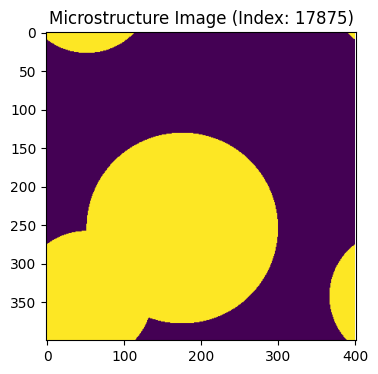

In [9]:
import matplotlib.pyplot as plt


model_jit = torch.jit.load('models/vrnn_therm2D_jit.pt')
print(train_feature)
kappa_pred = unpack_sym(model_jit(train_feature), dim=2)*kappa0

print(kappa_pred.cpu().detach().numpy())

plt.figure(figsize=(4, 4))
plt.imshow(image[0], cmap='viridis')
plt.title(f'Microstructure Image (Index: {image_index})')
plt.axis('equal')
plt.show()